In [1]:
	
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

In [26]:
df = pd.read_csv("combined.csv")
print(df['joules'].tolist())
df['joules'] = df['joules']/600.0

#print(df.columns.tolist())

[24432.59, 24625.04, 24309.92, 19185.02, 18939.17, 19095.14]


## Experiment
# Query1 sleep state analysis
4 nodes: 1 Job Manager, 1 Source, 1 Mapper, 1 Sink

# Run command
NITERS="2" FLINK_RATE="100000_600000" NSOURCES="16" NMAPPERS="4 16" NSINKS="16" ./run_query1.sh comboSMS

100K RPS for 10 mins with 16 source, 16 sinks and [4, 16] mappers


# Analysis
Both 4 and 16 mappers are able to meet the source 100K RPS target and Instruction counts is similar indicating both configurations did the same amount of the work. However, the 16 mapper resulted in power savings of 23%, and the interrupt difference is quite drastic as well.

Joules diff between 16 mappers vs 4 mappers: 0.7560975609756098
instructions diff between 16 mappers vs 4 mappers: 0.998426512775158
instructions diff between 16 mappers vs 4 mappers: 0.998426512775158


/tmp/ipykernel_138890/3602794679.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")
/tmp/ipykernel_138890/3602794679.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"instructions diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['instructions']) / int(df0[(df0.nmappers == 4)]['instructions'])}")
/tmp/ipykernel_138890/3602794679.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"instructions diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['instructions']) / int(df0[(df0.nmappers == 4)]['instructions'])}")


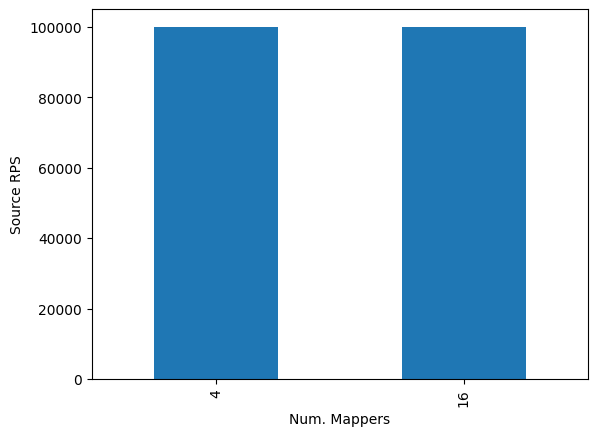

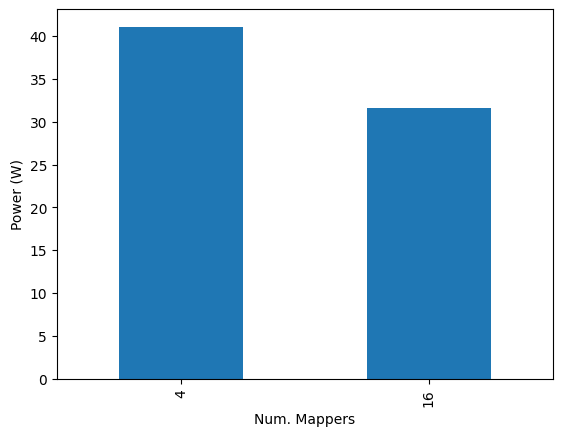

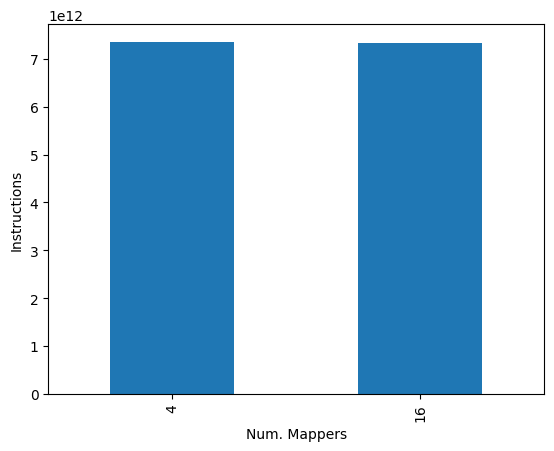

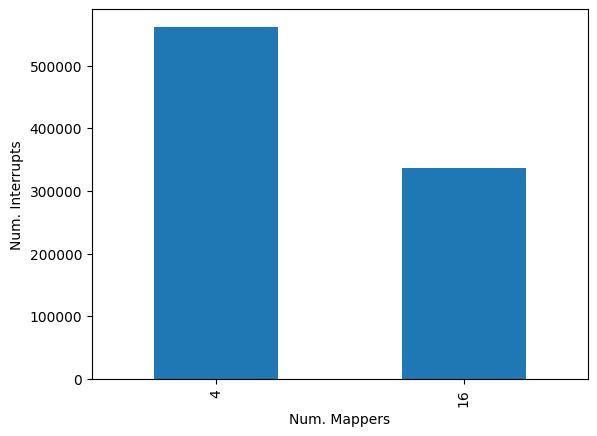

In [44]:
df0 = df[(df.i == 1)]

#df0
df0.plot(x="nmappers", y=["SourcenumRecordsOutPerSecond_avg"], kind="bar", ylabel="Source RPS", xlabel='Num. Mappers', legend=False) 
df0.plot(x="nmappers", y=["joules"], kind="bar", ylabel="Power (W)", xlabel='Num. Mappers', legend=False) 
df0.plot(x="nmappers", y=["instructions"], kind="bar", ylabel="Instructions", xlabel='Num. Mappers', legend=False) 
df0.plot(x="nmappers", y=["num_interrupts"], kind="bar", ylabel="Num. Interrupts", xlabel='Num. Mappers', legend=False) 

print(f"Joules diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['joules']) / int(df0[(df0.nmappers == 4)]['joules'])}")
print(f"instructions diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['instructions']) / int(df0[(df0.nmappers == 4)]['instructions'])}")
print(f"instructions diff between 16 mappers vs 4 mappers: {int(df0[(df0.nmappers == 16)]['instructions']) / int(df0[(df0.nmappers == 4)]['instructions'])}")


# Taking a look at multicore results

## Analysis
From the per-core results, we can see that overall the 16 Mapper configuration resulted in fewer interrupts overall. This suggests potentially 16 mappers had less busy cores than 4 mappers which makes sense as load is more evenly distributed.

The per core instruction also illustrates the results of pinning where for the 4 mappers, cores 15,14,13,12 showed the largest instruction counts in contrast to other cores as they are the busy worker threads.

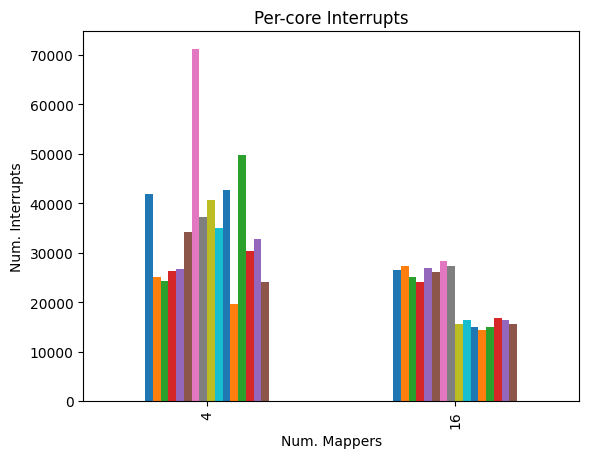

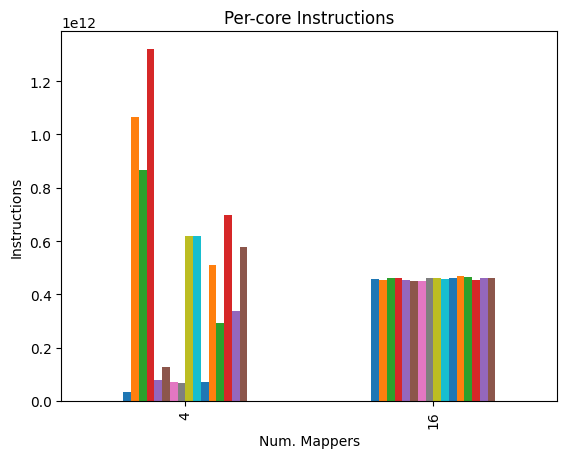

In [45]:
def plotMC(name, df, tname, yl, xl):
    ys=[]
    for core in range(0, 16):
        ys.append(f"core{core}_{name}")
    df.plot(x="nmappers", y=ys, kind="bar", legend=False, title=tname, ylabel=yl, xlabel=xl) 
plotMC('num_interrupts', df0, "Per-core Interrupts", "Num. Interrupts", "Num. Mappers")
plotMC('instructions_diff', df0, "Per-core Instructions", "Instructions", "Num. Mappers")


# Sleep State Analysis

Info: https://www.kernel.org/doc/html/v5.0/admin-guide/pm/cpuidle.html
time: Total time spent in this idle state by the given CPU (as measured by the kernel) in microseconds.
In the figure below, we show the time that each configuration of mapper spent in each of the states.

It shows that for 4 mapper vs 16 mapper case, the deepest sleep state, C6, Mapper4 spent 3685413472 us while Mapper16 spent 3939465988 us.

Mapper16 spent 6% more in deepest sleep state than Mapper4. We suspect this also contributed to energy difference. This seemest to indicate the classic behavior of pace-to-idle (Henry Hoffmann. 2013. Racing and pacing to idle: an evaluation of heuristics for energy-aware resource allocation. In Proceedings of the Workshop on Power-Aware Computing and Systems (HotPower '13). Association for Computing Machinery, New York, NY, USA, Article 13, 1–5. https://doi.org/10.1145/2525526.2525854)

If we sum up all of the recorded time spent in all of the sleep states: Mapper4 = 3907133830, Mapper16 = 4016468625


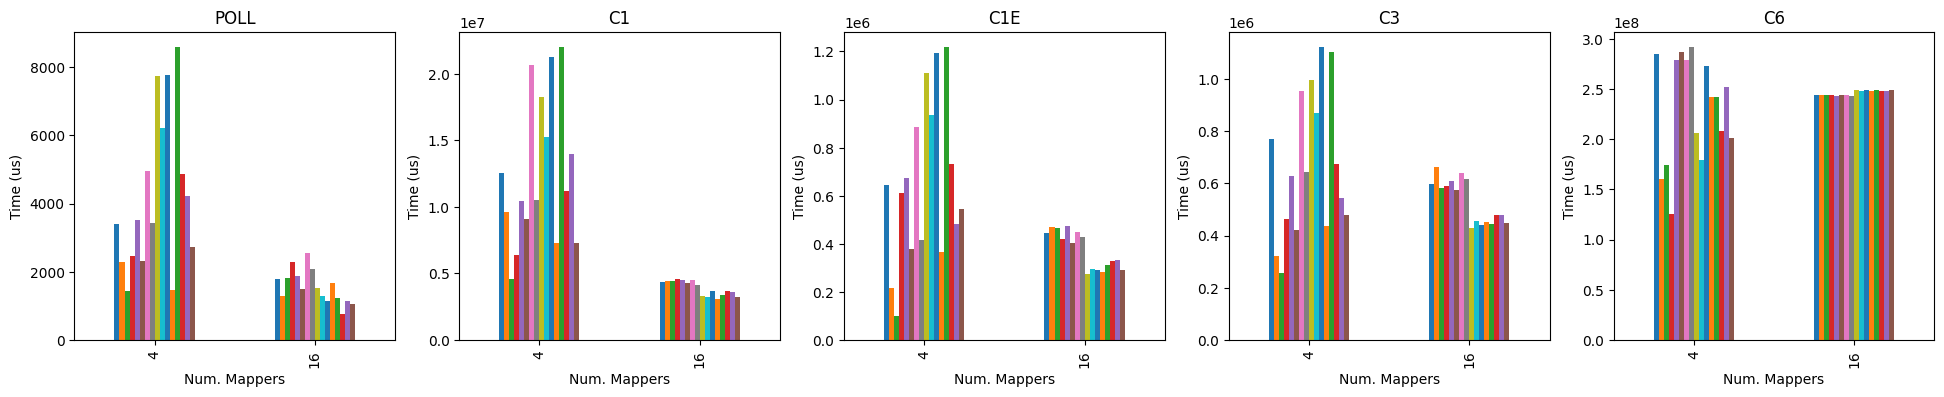

In [57]:
cdict = {
    0: 'POLL',
    1: 'C1',
    2: 'C1E',
    3: 'C3',
    4: 'C6'
}
def plotCS(state, name, axes, df, r=0):
    ys=[]
    for core in range(0, 16):
        ys.append(f"core{core}_state{state}_{name}")
    df.plot(x="nmappers", y=ys, kind="bar", legend=False, xlabel='Num. Mappers', ylabel='Time (us)', title=f"{cdict[state]}", ax=axes[state]) 
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,4))
plotCS(0, "time", axes, df0)
plotCS(1, "time", axes, df0)
plotCS(2, "time", axes, df0)
plotCS(3, "time", axes, df0)
plotCS(4, "time", axes, df0)

In [59]:
summap4 = 0
summap16 = 0
for state in range(0, 5):
    dfmapper4 = df0[(df0.nmappers == 4)]
    dfmapper16 = df0[(df0.nmappers == 16)]
    
    mapper4 = 0
    mapper16 = 0

    for core in range(0, 16):
        mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
        mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
    summap4 += mapper4
    summap16 += mapper16
    print(f"state{state}_time mapper4: {mapper4}, mapper16: {mapper16}, ratio (mapper4/mapper16) = {round(mapper4/mapper16,2)}")
print(f"summap4 = {summap4}, summap16 = {summap16}, ratio={summap4/summap16}")

state0_time mapper4: 67414, mapper16: 24994, ratio (mapper4/mapper16) = 2.7
state1_time mapper4: 200478453, mapper16: 62520478, ratio (mapper4/mapper16) = 3.21
state2_time mapper4: 10501999, mapper16: 5958315, ratio (mapper4/mapper16) = 1.76
state3_time mapper4: 10672492, mapper16: 8498850, ratio (mapper4/mapper16) = 1.26
state4_time mapper4: 3685413472, mapper16: 3939465988, ratio (mapper4/mapper16) = 0.94
summap4 = 3907133830, summap16 = 4016468625, ratio=0.972778376925576


/tmp/ipykernel_138890/2437406180.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper4 += int(dfmapper4[f"core{core}_state{state}_time"])
/tmp/ipykernel_138890/2437406180.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  mapper16 += int(dfmapper16[f"core{core}_state{state}_time"])
